# Spencer Hallyburton
# AM 207 Pset 2

## Collaborator: Salvador Barragan

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi as PI
import sympy as sym
import scipy
import scipy.integrate as integrate
from scipy.stats import truncnorm

DEC = 3

font_val = 18
plt.rc('font', size=font_val)          # controls default text sizes
plt.rc('axes', titlesize=font_val)
plt.rc('axes', labelsize=font_val)    # fontsize of the x and y labels
plt.rc('legend', fontsize=(font_val-3))    # legend fontsize
plt.rc('font', family='Sans Serif')


In [2]:
Nsamp = 200
Ntrials = 1000

## Problem 1: Monte Carlo Integration

0.001
X Area: 1.00
H Area: 0.56


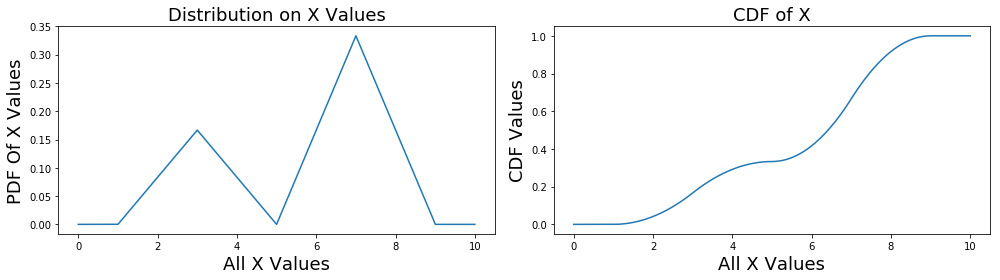

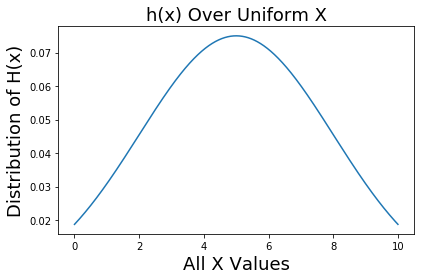

In [3]:
# Describe the distribution on X:
dx = 1 * (10**-DEC)
print(dx)

x = np.arange(0, 10, dx)
x_out = np.piecewise(x, [(x>=1) * (x<=3), (x>3) * (x<=5), (x>5) * (x<=7), (x>7) * (x<=9)], 
                [lambda x: 1/12*(x-1), lambda x: -1/12*(x-5), lambda x: 1/6*(x-5), lambda x: -1/6*(x-9)])

# Define function, h(X)
h = lambda x: 1/(3*np.sqrt(2)*PI) * np.exp(-1/18 * (x-5)**2)

# Check normalization condition on both:
area_X = np.trapz(x_out, x=x)
print('X Area: %.2f' % area_X)
area_H = integrate.quad(h, -1*np.inf, np.inf)
print('H Area: %.2f' % area_H[0])

# Plotting outputs
fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(x, x_out)
ax[0].set_title('Distribution on X Values')
ax[0].set_xlabel('All X Values')
ax[0].set_ylabel('PDF Of X Values')
CDF_X = np.cumsum(dx*x_out)
ax[1].plot(x, CDF_X)
ax[1].set_title('CDF of X')
ax[1].set_xlabel('All X Values')
ax[1].set_ylabel('CDF Values')
plt.tight_layout()
plt.show()

# Plot h(x)
fig, ax = plt.subplots()
ax.plot(x, h(x))
ax.set_title('h(x) Over Uniform X')
ax.set_xlabel('All X Values')
ax.set_ylabel('Distribution of H(x)')
plt.tight_layout()
plt.show()

### Method 1: Inverse Transform Sampling

In [4]:
##################################################################
# Define a function for inverse sampling
def Perform_Inverse(Nsamp, x, x_out, CDF_X):
    # Sample uniformly from CDF of X
    y_rand = np.random.rand(Nsamp)
    y_rand = np.round(y_rand, decimals=DEC)
    CDF_X = np.round(CDF_X, decimals=DEC)

    # Map the y value back to X on the CDF:
    locs = []
    for yval in y_rand:
        A = np.argmax(CDF_X==yval)
        locs.append(A)

    # Get the mean value:
    h_exp_1 = np.mean(h(x[locs]))

    return(h_exp_1, locs)
##################################################################

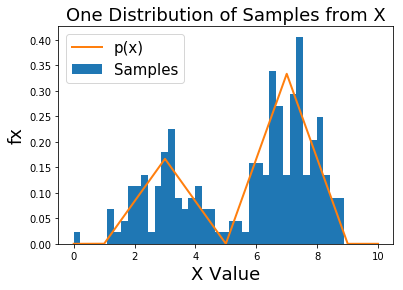

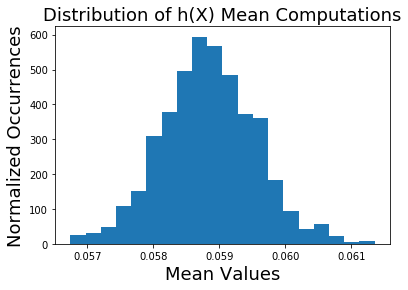

Expectation: E[h(X)] = 0.05884


In [5]:
# Evaluate the inverse sampling function
_, locs = Perform_Inverse(Nsamp, x, x_out, CDF_X)

h_out_1 = np.zeros(Ntrials)
for m in range(Ntrials):
    h_out_1[m], _ = Perform_Inverse(Nsamp, x, x_out, CDF_X)

# Plot the histogram:
plt.hist(x[locs], bins=40, normed=True,label=u'Samples')
plt.plot(x, x_out, linewidth=2, label=u'p(x)')
plt.title('One Distribution of Samples from X')
plt.xlabel('X Value')
plt.ylabel('fx')
plt.legend()
plt.show()

# Plot the histogram of mean values:
plt.hist(h_out_1, bins=20, normed=True)
plt.title('Distribution of h(X) Mean Computations')
plt.ylabel('Normalized Occurrences')
plt.xlabel('Mean Values')
plt.show()

# Compute expectation of this:
print('Expectation: E[h(X)] = %.5f' % np.mean(h_out_1))

### Method 2: Rejection Sampling

#### a) Uniform Proposal Distribution

In [6]:
##################################################################
# Define a function for rejection sampling
def Perform_Rejection_Uniform(Nsamp, x, x_out):
    accepted = 0
    samples = np.zeros(Nsamp)
    count = 0
    xmin = 1
    xmax = 9
    ymax = max(x_out)
    
    # Loop over to draw samples
    while (accepted < Nsamp):
        # Step 1: Draw uniform x from min to max
        xrand = np.round(np.random.uniform(xmin, xmax), decimals=DEC)

        # Step 2: Pick uniform on [0, ymax)
        yrand = np.random.uniform(0, ymax)

        # Step 3: Do the accept/reject comparison
        if yrand < x_out[np.where(x == xrand)]:
            samples[accepted] = xrand
            accepted += 1
        count += 1

    return(samples, count, accepted)
##################################################################

Count: 624 Accepted: 200


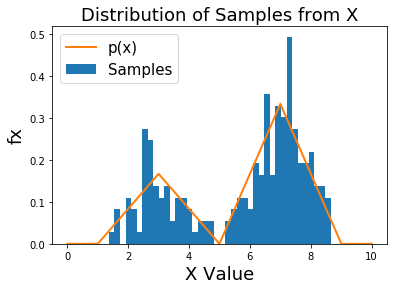

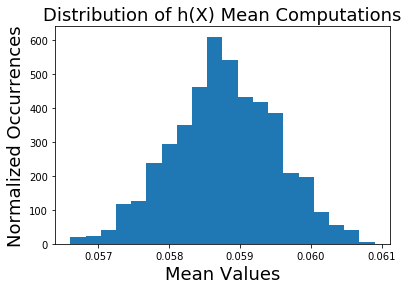

Expectation: E[h(X)] = 0.05878


In [7]:
# Evaluate the rejection sampling
samples2, count2, accepted2 = Perform_Rejection_Uniform(Nsamp, x, x_out)
print("Count:",count2, "Accepted:", accepted2)

# Plot the histogram:
plt.hist(samples2, bins=40, normed=True, label=u'Samples')
plt.plot(x, x_out, linewidth=2, label=u'p(x)')
plt.title('Distribution of Samples from X')
plt.xlabel('X Value')
plt.ylabel('fx')
plt.legend()
plt.show()


# Evaluation the Rejection Sampling many times
h_out_2 = np.zeros(Ntrials)
for m in range(Ntrials):
    samples2_all, _, _ = Perform_Rejection_Uniform(Nsamp, x, x_out)
    h_out_2[m] = np.mean(h(samples2_all))
    
# Plot the histogram of mean values:
plt.hist(h_out_2, bins=20, normed=True)
plt.title('Distribution of h(X) Mean Computations')
plt.ylabel('Normalized Occurrences')
plt.xlabel('Mean Values')
plt.show()

print('Expectation: E[h(X)] = %.5f' % np.mean(h_out_2))

#### b) Normal Proposal Distribution (Steroids)

In [8]:
# Create a proposal pdf: Normal Distribution
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*PI)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

mu_1 = 6
sigma_1 = 3
Mg = lambda x: 2.8*gaussian(x, mu_1, sigma_1)
invCDFg = lambda x: dx*np.sum(Mg(np.arange(1-dx, x, dx))) # generates our proposal using inverse sampling
CDFvals = np.round( list(map(lambda val: invCDFg(val), x)), decimals= DEC)

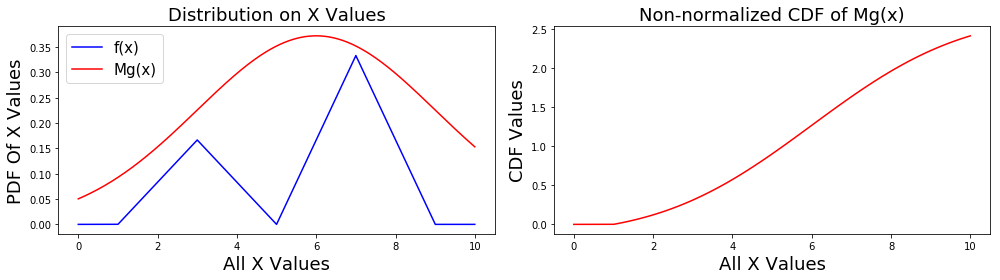

Inverse Sampling Range: (0.00019, 2.22198)


In [9]:
# domain limits
xmin = 1 # the lower limit of our domain
xmax = 9 # the upper limit of our domain

# Show proposal overlayed on Normal distribution
# Plotting outputs
fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(x, x_out,'b', label=u'f(x)')
ax[0].plot(x, Mg(x),'r', label=u'Mg(x)')
ax[0].set_title('Distribution on X Values')
ax[0].set_xlabel('All X Values')
ax[0].set_ylabel('PDF Of X Values')
ax[0].legend()
ax[1].plot(x, CDFvals, 'r')
ax[1].set_title('Non-normalized CDF of Mg(x)')
ax[1].set_xlabel('All X Values')
ax[1].set_ylabel('CDF Values')
plt.tight_layout()
plt.show()

# range limits for inverse sampling
umin = invCDFg(xmin)
umax = invCDFg(xmax)
print('Inverse Sampling Range: (%.5f, %.5f)' % (umin, umax))


In [10]:
##################################################################
# Define a function for rejection sampling on steroids
def Perform_Rejection_Steroids(Nsamp, x, x_out, Mg, lower, upper, mu, sigma):
    accepted = 0
    samples = np.zeros(Nsamp)
    count = 0
    
    # Sample from normal:
    X = truncnorm( (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma  )
    Xvals = np.round( X.rvs(4*Nsamp), decimals = DEC)
    
    # Generation Loop
    while (accepted < Nsamp):
        # Get a proposal X value from truncated normal
        xproposal = Xvals[count]
        
        # Pick a uniform number on [0, 1)
        y = np.random.uniform(0,1)

        # Do the accept/reject comparison
        p = x_out[np.argmax(x==xproposal)]
        if y < p / Mg(xproposal):
            samples[accepted] = xproposal
            accepted+=1
        count += 1

    return(samples, count, accepted)
##################################################################

Count: 461 Accepted: 200


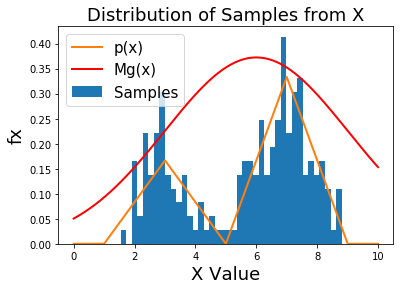

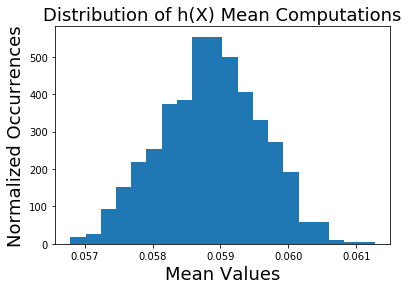

Expectation: E[h(X)] = 0.05885


In [11]:
# Evaluate the rejection sampling on steroids
# Nsamp = 1000
# Ntrials = 300
samples3, count3, accepted3 = Perform_Rejection_Steroids(Nsamp, x, x_out, Mg, xmin, xmax, mu_1, sigma_1)

print("Count:",count3, "Accepted:", accepted3)

# Plot the histogram:
plt.hist(samples3, bins=40, normed=True, label=u'Samples')
plt.plot(x, x_out, linewidth=2, label=u'p(x)')
plt.plot(x, Mg(x), 'r', linewidth=2, label=u'Mg(x)')
plt.title('Distribution of Samples from X')
plt.xlabel('X Value')
plt.ylabel('fx')
plt.legend()
plt.show()

# Evaluation the Rejection Sampling many times
h_out_3 = np.zeros(Ntrials)
for m in range(Ntrials):
    samples3_all, _, _ = Perform_Rejection_Steroids(Nsamp, x, x_out, Mg, xmin, xmax, mu_1, sigma_1)
    h_out_3[m] = np.mean(h(samples3_all))
    
# Plot the histogram of mean values:
plt.hist(h_out_3, bins=20, normed=True)
plt.title('Distribution of h(X) Mean Computations')
plt.ylabel('Normalized Occurrences')
plt.xlabel('Mean Values')
plt.show()

# Compute expectation:
print('Expectation: E[h(X)] = %.5f' % np.mean(h_out_3))

## Problem 2: Variance Reduction

### Part a) Variance Assessment

In [12]:
# Computing Variance of each estimate of expectation:
print('Variance for each method\n\nInverse: %.4e\nRejection 1: %.4e\nRejection 2: %.4e'
      % (np.var(h_out_1), np.var(h_out_2), np.var(h_out_3)))

Variance for each method

Inverse: 5.0900e-07
Rejection 1: 5.4454e-07
Rejection 2: 5.3893e-07


After computing the variances for each of the methods, we see that they are all reasonbly close together. We can then posit that each of these methods is equivalent in terms of the variance in their prediction.

### Part b) Stratified Sampling

In [21]:
print(sigmas)

[ 1.23261163  2.05335352]


In [120]:
# Step 1: Find a natural way to divide the domain of X - divide into 2 strata
Ns = 2 # Number of strata
Ntry = 1000 # Number of tries in each region
xmin = 1
xmax = 9

step = (xmax - xmin)/Ns
sigmas = np.zeros(Ns)

# Pick out x according to f(x) (inverse sampling?)
yinit = np.round( np.random.rand(Ntry), decimals=DEC)

locs = []
CDF_try = np.round(CDF_X, decimals=DEC)
for yval in yinit:
    A = np.argmax(CDF_try==yval)
    locs.append(A)

Utry = x[locs]

# When calculating the number of samples in each region, figure out the variation in the h values you observe
Ytry = h(Utry)
Umin = 0
Umax = step

# Calculate standard deviation of points in each region
for reg in np.arange(0,Ns):
    localmask = (Utry >= Umin) & (Utry < Umax)

    sigmas[reg] = np.std(Ytry[localmask])
    Umin = Umin + step
    Umax = Umax + step

# Store probability of each region
p1 = CDF_X[np.where(x==5)]
p2 = CDF_X[np.where(x==9)] - CDF_X[np.where(x==5)]
p_vec = np.asarray([p1, p2])
p_vec = p_vec.reshape(1,-11)

nums = np.ceil(Ntry*p_vec*sigmas/np.sum(p_vec*sigmas)).astype(int)
nums = nums.reshape(1,-1)
# Determine parameters for normal proposals and show on plot:
mu_vals = [3, 7]
sigma_vals = [1, 1]
nums = nums[0]
print(nums)

[395 606]


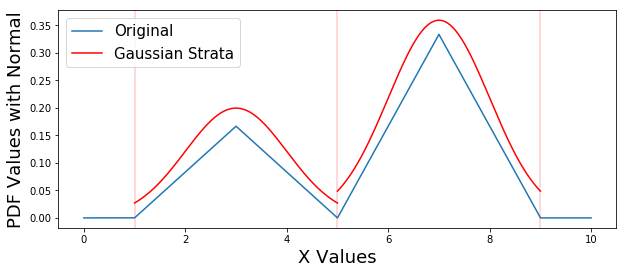

In [122]:
Mg1 = lambda x: 1/2*gaussian(x, mu_vals[0], sigma_vals[0])
x1 = x[(x>=xmin) & (x<=(xmin+step))]
Mg2 = lambda x: 9/10*gaussian(x, mu_vals[1], sigma_vals[1])
x2 = x[(x>=(step+xmin)) & (x<=xmax)]

fig = plt.figure(figsize=(10,4))
plt.plot(x, x_out, label='Original')
for j in range(Ns+1):
    plt.axvline(xmin + j*step, 0, 1, color='r', alpha=0.2)
plt.plot(x1, Mg1(x1), color='r', label=u'Gaussian Strata')
plt.plot(x2, Mg2(x2), color='r')
plt.xlabel('X Values')
plt.ylabel('PDF Values with Normal')
plt.legend()
plt.show()

In [123]:
##################################################################
# Define a function for rejection sampling for stratefied region
def Perform_Rejection_Stratefied(Nsamp, x, x_out, Mg, lower, upper, mu, sigma):
    accepted = 0
    samples = np.zeros(Nsamp)
    count = 0
    
    # Sample from normal:
    X = truncnorm( (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma  )
    Xvals = np.round( X.rvs(Nsamp * 4), decimals = DEC)

    # Generation Loop
    while (accepted < Nsamp):
        # Get a proposal X value from truncated normal
        xproposal = Xvals[count]
        
        # Pick a uniform number on [0, 1)
        y = np.random.uniform(0,1)

        # Do the accept/reject comparison
        p = x_out[np.argmax(x==xproposal)]
        if y < p / Mg(xproposal):
            samples[accepted] = xproposal
            accepted+=1
        count += 1

    return(samples, count, accepted)
##################################################################

In [124]:
# Calculate number of points for sampling in each region
Nsamp = 2000
Ntrials = 200

count_all = 0
accepted_all = 0
Is = np.zeros(Ntrials)

# Loop over each trial
for k in np.arange(0, Ntrials):
    # Start in the first region with everything set to zero
    Umin = xmin
    Umax = step+xmin
    Ii = 0
    
    # Loop over each region
    for reg in np.arange(0, Ns):
        # Sample using rejection sampling:
        idxes = (x>=Umin) & (x<=Umax)
        x_st = x[idxes]
        x_out_st = x_out[idxes]
        weight = CDF_X[np.where(x==Umax)] - CDF_X[np.where(x==Umin)]
        if reg==0:
            Mg = lambda x: Mg1(x)
        elif reg==1:
            Mg = lambda x: Mg2(x)
        
        # Rejection sampling using number of points as proportional to size of region
        samples, count, accepted = Perform_Rejection_Stratefied(nums[reg], x_st, x_out_st, Mg, Umin, Umax, 
                                                                mu_vals[reg], sigma_vals[reg])
        
        count_all += count
        accepted_all += accepted
        
        #Add points in weighted fashion
        Ii = Ii + weight*np.mean(h(samples))

        # Update the region
        Umin = Umin + step
        Umax = Umax + step
        
    # Add integral value
    Is[k] = Ii
    
print('count:', count_all, 'accept:', accepted_all)

count: 314312 accept: 200200


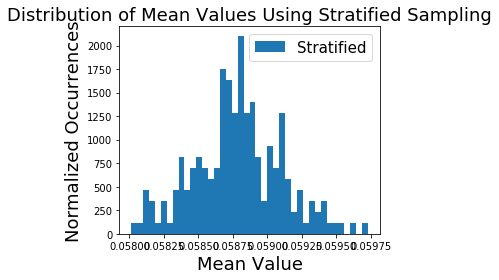

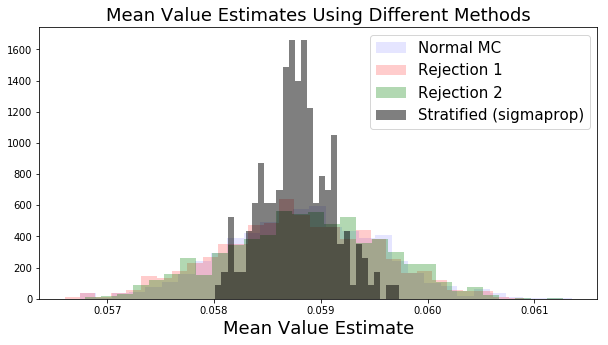

Mean Value Calculation: 0.0588
Variance Using Stratified: 1.0159e-07


In [125]:
# Plot stratified sampling method
plt.hist(Is, bins=40, histtype='stepfilled', label=u'Stratified', normed=True)
plt.legend()
plt.title('Distribution of Mean Values Using Stratified Sampling')
plt.xlabel('Mean Value')
plt.ylabel('Normalized Occurrences')
plt.tight_layout()
plt.show()

# Plot all three methods at once:
plt.figure(figsize=(10,5))
plt.hist(h_out_1,30, histtype='stepfilled', color='b', label=u'Normal MC', alpha=0.1, normed=True)
plt.hist(h_out_2,30, histtype='stepfilled', color='r', label=u'Rejection 1', alpha=0.2, normed=True)
plt.hist(h_out_3, 30, histtype='stepfilled',color='g', label=u'Rejection 2', alpha=0.3, normed=True)
plt.hist(Is, 30, histtype='stepfilled',color='k', label=u'Stratified (sigmaprop)', alpha=0.5, normed=True)
plt.xlabel('Mean Value Estimate')
plt.title('Mean Value Estimates Using Different Methods')
plt.legend()
plt.show()

print('Mean Value Calculation: %.4f' % np.mean(Is))
print('Variance Using Stratified: %.4e' % np.var(Is))


## Problem 3: Linear Regression¶


### Part a) Create Linear Regression Class

In [5]:
class Regression(object):
    
    def __init__(self):
        self.params = dict()
    
    def get_params(self, k):
        return self.params[k]
    
    def set_params(self, **kwargs):
        for k,v in kwargs.items():
            self.params[k] = v
        
    def fit(self, X, y):
        raise NotImplementedError()
        
    def predict(self, X):
        raise NotImplementedError()
        
    def score(self, X, y):
        raise NotImplementedError()



In [6]:
class OLS(Regression):
    def __init__(self):
        Regression.__init__(self)
        
    def fit(self, X, y):
        # Add a column of one's to the X matrix
        n,m = X.shape
        X0 = np.ones((n,1))
        X = np.hstack((X,X0))
        
        # Fit a least squares linear regression
        inv_mat = np.linalg.pinv(X.T.dot(X))
        bhat =  inv_mat.dot(X.T).dot(y)
        
        # Set the parameters for self based on this fit
        self.set_params(intercept=bhat[m:m+1], coef=bhat[0:m])
        
    def predict(self, X):
        # Add a column of one's to the X matrix
        n,m = X.shape
        X0 = np.ones((n,1))
        X = np.hstack((X,X0))
        
        # Make predictions
        yhat = X.dot( np.hstack((lr.get_params('coef'), lr.get_params('intercept'))) )
        return(yhat)
        
    def score(self, X, y):
        ybar = np.mean(y)
        yhat = self.predict(X)
        SS_T = np.sum((y - ybar)**2)
        SS_E = np.sum((y - yhat)**2)
        score = 1 - SS_E / SS_T
        return(score)
    

R-Squared Score: 1.000:

Optimal Coefficients:
 [ 76.6568183   77.67682678  63.78807738  19.3299907   59.01638708
  53.13633737  28.77629958  10.01888939   9.25346811  59.55220395]

My Calculated Coefficients:
 [ 77.20719705  76.51004831  62.97865316  18.4436452   58.50019885
  53.25126559  28.29088241   9.33333359  10.29584457  59.1606719 ]


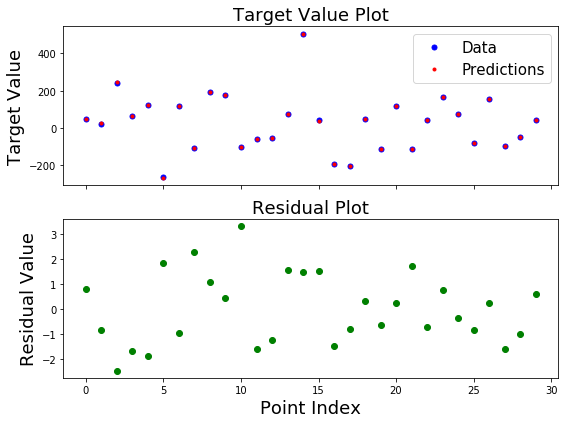

In [8]:
from sklearn.datasets import make_regression
np.random.seed(99)
X, y, coef = make_regression(30,10, 10, bias=1, noise=2, coef=True)

# Run least squares regression
lr = OLS()
lr.fit(X,y)
B1 = lr.get_params('coef')
yhat = lr.predict(X)
R2 = lr.score(X,y)
print('R-Squared Score: %.3f:' % R2)

# Compare coefficients
print('\nOptimal Coefficients:\n', coef)
print('\nMy Calculated Coefficients:\n', B1)

# Display the plot of the residuals
fig, ax = plt.subplots(2,1,figsize=(8,6), sharex=True)
ax[0].plot(y, 'bo', markersize=5, label='Data')
ax[0].plot(yhat, 'ro', markersize=3, label='Predictions')
ax[0].set_title('Target Value Plot')
ax[0].set_ylabel('Target Value')
ax[0].legend()
ax[1].plot(y - yhat, 'go')
ax[1].set_title('Residual Plot')
ax[1].set_xlabel('Point Index')
ax[1].set_ylabel('Residual Value')
plt.tight_layout()
plt.show()